# Goal of this notebook is: 

to create the final multi-input model based on the models for the text part and the product type part

# Import Libraries

In [1]:
import datetime
import itertools
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import Input
from keras import layers
from keras import models
from keras import regularizers
from keras import utils
from keras.models import Model
from keras.utils import to_categorical
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.models import save_model


%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

# Parameters

In [3]:
logging = True

saving = True

PARAMS = {

    # Define experiment name:
    'experiment_name': 'final_multi_input_model',

    # Parameters general:
    'number_of_classes': len(np.unique(train_descr['Sentiment'])),
    'n_splits': 4,
    'seed': 42,
    'batch_size': 32,
    'epochs': 50,
    'hidden_units_text': 32,
    'hidden_units_product': 64,

    # NLP Parameters
    # max_words = vocabulary size = our samples - number of most frequent words.
    # I set it to 10.000, although in this case there are less.
    # I do this to parametise the code.
    # Aleternatively, I can set it to the length of our vocabulary = word_index
    'max_words': 10000,

    # embedding_size = embedding dimensionality
    'embedding_size': 30,  # [10, 20, 30, 100],

    # Cross-fold validation:
    'k': 4,
}

logdir = f'logs/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")
logdir_tb = f'logs/tensorboard/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")

# create logging folder and tensorboard callback function
if logging:
    print(f'Log results to {logdir}')
    if not os.path.exists(logdir):
        os.makedirs(logdir)

    tensorboard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir_tb)]

else:
    logdir = ''
    logdir_tb = ''
    tensorboard_callbacks = []

Log results to logs/experiments/final_multi_input_model_2020_12_19-22:07


# Load Tokens and Vocabulary

In [4]:
def load_data(path_to_corpus, one_hot=False):
    """
    Loads the tokenised text and produces the labels. 
    If one-hot encoded is not needed, the data is also padded. 

    Args: 
        - path_to_corpus - path to tokenised text
        - one_hot - if the model is bag-of-words, one-hot-encoded data is used. The default is False

    Returns:
        - sequences - tokenised text
        - word_index - a dictionary having as key the word and as value its index
        - data - in case of one_hot=False the padded sequences
        - labels - the sentiments 
    """

    sequences, word_index = pd.read_pickle(path_to_corpus)

    if not one_hot:
        # max_len = sequence length - the text is cut off after this number of words
        # in this case it is defined as the maximum sequence length in our list of tokenised sequences
        max_len = np.max([len(x) for x in sequences])
        data = tf.keras.preprocessing.sequence.pad_sequences(
            sequences, maxlen=max_len)
    else:
        data = sequences

    labels = train_descr.loc[:, 'Sentiment'].to_list()

    return sequences, word_index, data, labels

#### Load Text Data

In [5]:
sequences_oh, word_index_oh, text_oh, labels = load_data(
    preprocessed_corpus_path_TF_oh, one_hot=True)
sequences_oh.shape

# if text model was with embedding layer
#sequences, word_index, text, labels = load_data(preprocessed_corpus_path_TF)
#print(f'Shape of sequences after padding is {text.shape}')

(6364, 10000)

Add max_len to parameters dictionary

In [6]:
# if text model was with embedding layer
#max_len = np.max([len(x) for x in sequences])
#PARAMS['max_len'] = max_len

#### Load Product_Type Data

In [7]:
product_type = train_descr.loc[:, 'Product_Type']

# Train-Test Split

In [8]:
def train_test_split(data, labels):
    """
    Splits the data into train and test data sets.
    One-hot encodes the labels.

    Args: 
        - data - preprocessed text_data
        - labels - sentiments

    Returns: 
        - x_train, y_train_oh - training text data & the corresponding one-hot encoded labels
        - x_test, y_test_oh - test text data & the corresponding one-hot encoded labels
    """
    dimensions_labels = PARAMS['number_of_classes']

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = np.asarray(labels)
    labels = labels[indices]

    training_samples = int(0.8 * len(data))

    x_train = data[:training_samples]
    y_train = labels[:training_samples]

    x_test = data[training_samples:]
    y_test = labels[training_samples:]

    y_train_oh = tf.one_hot(indices=y_train, depth=dimensions_labels)
    y_train_oh = np.asarray(y_train_oh)

    y_test_oh = tf.one_hot(indices=y_test, depth=dimensions_labels)
    y_test_oh = np.asarray(y_test_oh)

    return x_train, y_train_oh, x_test, y_test_oh

In [9]:
x_train_text, y_train, x_test_text, y_test = train_test_split(
    text_oh, labels)

x_train_product_type, _, x_test_product_type, _ = train_test_split(
    product_type, labels)

# Preparation for Model Generation & Training

### Function for Oversampling the Minority Classes

SMOTE = Synthetic Minority Oversampling Technique. It was chosen, because the data set is small and oversampling will, even if synthetically, increase it.

In [10]:
def oversample_smote(x_train, y_train):
    """
    This function produces an oversampled set of train data using SMOTE

    Args: 
        - x_train - imbalanced train features (= text descriptions)
        - y_train - imbalanced train labels (= sentiments)

    Returns: 
        - x_train - oversampled train features (= text descriptions)
        - y_train - oversampled train labels (= sentiments)

    """
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    return x_train, y_train

# Generate the multi-input model

In [11]:
hidden_units_text = PARAMS['hidden_units_text']
hidden_units_product = PARAMS['hidden_units_product']
dimensions_labels = PARAMS['number_of_classes']
max_words = PARAMS['max_words']
#max_len = PARAMS['max_len']
embedding_size = PARAMS['embedding_size']

### 1. Text part

The model will be built based on the optimal model defined in Notebook 02_NLP_Model_Choice_Optimisation: bag-of-words with both l2 and dropout

In [12]:
# input
text_input = Input(shape=(None,), dtype='int32', name='text')
print(text_input.shape)

# preparation for the FC layer
fc_prep_text = layers.Reshape((max_words,))(text_input)
print(fc_prep_text.shape)

# 2 fully connected layers with regularisation
text_1 = layers.Dense(hidden_units_text, kernel_regularizer=regularizers.l2(
), activation='relu')(fc_prep_text)
text_2 = layers.Dropout(0.5)(text_1)
text_3 = layers.Dense(
    hidden_units_text, kernel_regularizer=regularizers.l2(), activation='relu')(text_2)
text_4 = layers.Dropout(0.5)(text_3)

(None, None)
(None, 10000)


### 2. Product_Type part

In [13]:
# input
product_input = Input(shape=(None,), dtype='int32', name='product_type')
print(product_input.shape)

# preparation for the FC layer
fc_prep_product = layers.Reshape((1,))(product_input)
print(fc_prep_product.shape)

# 2 fully connected layers
product_1 = layers.Dense(hidden_units_product,
                         activation='relu')(fc_prep_product)
product_2 = layers.Dense(hidden_units_product, activation='relu')(product_1)

(None, None)
(None, 1)


#### 3. Concatenate

In [14]:
concatenated = layers.concatenate([text_4, product_2], axis=-1)

In [15]:
sentiment = layers.Dense(dimensions_labels, activation='softmax')(concatenated)

#### 4. Model Initiation

In [16]:
model = Model([text_input, product_input], sentiment)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 10000)        0           text[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           320032      reshape[0][0]                    
__________________________________________________________________________________________________
product_type (InputLayer)       [(None, None)]       0                                            
______________________________________________________________________________________________

In [17]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

# Training with Cross-Validation (incl. Upsampling)

* Due to the small data quantity, cross-validation will be used to train the models.
* Furthermore, as the classes are imbalanced, an oversampling will be introduced. ! It is important to generate the training and validation sets BEFORE the upsampling. Otherwise the exact same observations could be present in both the train and validation sets, i.e. data leakage would occur. This can allow the model to simply memorize specific data points and cause overfitting and poor generalization on unseen data. 
* The oversampling will be applied only on the train set in order to ensure that the model generalises well on unseen data (validation set and ultimately test set)

In [19]:
def train_with_cross_val(k, model, train_text, train_product, train_labels, epochs, batch_size):
    """
    This function applies a k-fold cross-validation and saves the model history per fold & epoch.
    Args: 
        - k - number of folds
        - model - compiled model
        - train_text - the tokenised, padded and shuffled sequences
        - train_product - the product_type data
        - train_labels - labels 
        - epochs - number of epochs
        - batch_size - batch size
    """
    num_val_samples = len(train_text) // k

    for i in range(k):
        print('processing fold #', i)
        val_text = train_text[i * num_val_samples:(i + 1) * num_val_samples]
        val_product = train_product[i *
                                    num_val_samples:(i + 1) * num_val_samples]
        val_labels = train_labels[i *
                                  num_val_samples:(i + 1) * num_val_samples]

        partial_train_text = np.concatenate(
            [train_text[:i * num_val_samples],
             train_text[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_product = np.concatenate(
            [train_product[:i * num_val_samples],
             train_product[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_labels = np.concatenate(
            [train_labels[:i * num_val_samples],
             train_labels[(i + 1) * num_val_samples:]],
            axis=0
        )

        partial_train_product = partial_train_product.reshape(-1, 1)

        partial_train_text_ovs, partial_train_labels_ovs = oversample_smote(
            partial_train_text, partial_train_labels)

        partial_train_product_ovs, _ = oversample_smote(
            partial_train_product, partial_train_labels)

        history = model.fit(
            [partial_train_text_ovs, partial_train_product_ovs],  # multiple inputs
            partial_train_labels_ovs,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=([val_text, val_product],
                             val_labels),  # multiple inputs
            # callbacks=tensorboard_callbacks
        )

        np.save(f'history_multi_input_fold_{i}.npy', history.history)

    if saving:
        path = os.path.join(logdir, 'multi_input_fold')
        model.save(path)

# Baseline Model

Idea Model: https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


* As the Fully Connected NN model's the precision, recall and f1 are calculcated unweighted, precision, recall & f1 are chosen to be macro
* According to the sklearn-documentation this method calculates the metrics for each label, and finds their unweighted mean and does not take label imbalance into account.
* Example documentation for precision: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

Note: test_[metric] is validation and therefore comparable to the val_[metric] of the model.

In [20]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [21]:
model_base = DummyClassifier(strategy='most_frequent')

In [22]:
x_train_base = np.concatenate(
    (x_train_text, x_train_product_type.to_numpy().reshape(-1, 1)), axis=1)
y_train_base = y_train

In [23]:
cv = KFold(n_splits=PARAMS['k'], random_state=PARAMS['seed'])

scores = cross_validate(
    model_base, x_train_base, y_train_base, scoring=scoring, cv=cv, n_jobs=-1)

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [24]:
for metric, score in scores.items():
    print(f'Mean {metric}: %.3f (%.3f)' %
          (np.mean(score), np.std(score)))

Mean fit_time: 1.271 (0.080)
Mean score_time: 0.025 (0.007)
Mean test_accuracy: 0.593 (0.016)
Mean test_precision_macro: 0.148 (0.004)
Mean test_recall_macro: 0.250 (0.000)
Mean test_f1_macro: 0.186 (0.003)


# Train the Model

In [25]:
model = model
train_with_cross_val(
    PARAMS['k'], model, x_train_text, x_train_product_type, y_train, PARAMS['epochs'], PARAMS['batch_size'])

processing fold # 0


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/final_multi_input_model_2020_12_19-22:07/multi_input_fold/assets


# Evaluate the Model

* The model performs better than the baseline model
* Furthermore the graphs visualising the training and validation loss show that it generalises well - no significant gap between them
* The results on the final test set show definietely room for improvement. 
* They could be optimised by:
    * adding more data
    * test more hyperparameters
    * work with optimal epochs, i.e. stop training at the epoch, where the loss is at its minimum)

### Generate a Metrics Dataframe

In [26]:
history_all_df = pd.DataFrame()

for i in range(PARAMS['k']):
    history = np.load(
        f'history_multi_input_fold_{i}.npy', allow_pickle='TRUE').item()

    history_df = pd.DataFrame(history)

    history_df['f1'] = 2 * history_df.precision * \
        history_df.recall/(history_df.precision + history_df.recall)
    history_df['f1'] = history_df['f1'].fillna(0)
    history_df['val_f1'] = 2 * history_df.val_precision * \
        history_df.val_recall / \
        (history_df.val_precision + history_df.val_recall)
    history_df['val_f1'] = history_df['val_f1'].fillna(0)

    history_all_df = history_all_df.append(history_df)

history_all_df.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,f1,val_f1
0,1.460587,0.351969,0.480938,0.017943,1.215139,0.386792,0.613636,0.021226,0.034596,0.041033
1,1.223319,0.450656,0.548963,0.104267,1.158523,0.493711,0.623100,0.161164,0.175248,0.256090
2,1.188957,0.479540,0.573361,0.153063,1.153056,0.481132,0.617155,0.231918,0.241623,0.337143
3,1.173137,0.495186,0.582524,0.183807,1.143161,0.510220,0.593707,0.341195,0.279441,0.433350
4,1.159298,0.509081,0.596171,0.224836,1.146592,0.476415,0.611399,0.185535,0.326527,0.284680


In [27]:
history_all_df.mean()

loss             1.008515
accuracy         0.655350
precision        0.704850
recall           0.549100
val_loss         1.176928
val_accuracy     0.591663
val_precision    0.632349
val_recall       0.531553
f1               0.612973
val_f1           0.573166
dtype: float64

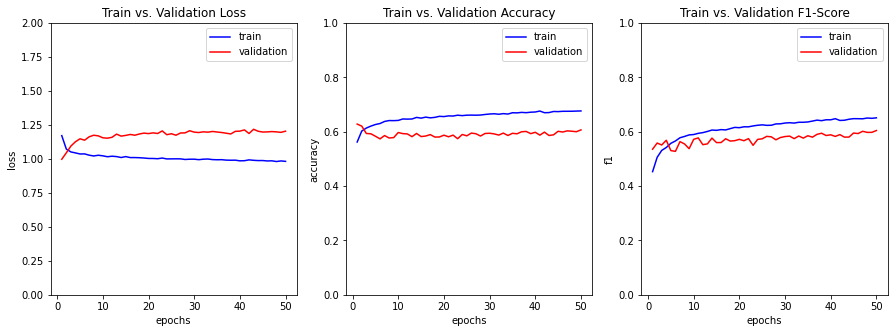

In [28]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)

epochs = PARAMS['epochs']
epochs_graph = range(1, PARAMS['epochs'] + 1)
folds = PARAMS['k']

loss_all = history_all_df.loc[:, 'loss'].to_list()
loss_prep = [loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
loss = [np.mean([x[i] for x in loss_prep]) for i in range(epochs)]

val_loss_all = history_all_df.loc[:, 'val_loss'].to_list()
val_loss_prep = [
    val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
val_loss = [np.mean([x[i] for x in val_loss_prep]) for i in range(epochs)]

accuracy_all = history_all_df.loc[:, 'accuracy'].to_list()
accuracy_prep = [
    accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
accuracy = [np.mean([x[i] for x in accuracy_prep]) for i in range(epochs)]

val_accuracy_all = history_all_df.loc[:, 'val_accuracy'].to_list()
val_accuracy_prep = [val_accuracy_all[i *
                                      epochs:(i + 1) * epochs] for i in range(folds)]
val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                for i in range(epochs)]

f1_all = history_all_df.loc[:, 'f1'].to_list()
f1_prep = [f1_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

val_f1_all = history_all_df.loc[:, 'val_f1'].to_list()
val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
               for i in range(folds)]
val_f1 = [np.mean([x[i] for x in val_f1_prep]) for i in range(epochs)]

plt.plot(epochs_graph, loss, 'b')
plt.plot(epochs_graph, val_loss, 'r')
plt.ylim([0, 2])
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation Loss')

ax = plt.subplot(132)
plt.plot(epochs_graph, accuracy, 'b')
plt.plot(epochs_graph, val_accuracy, 'r')
plt.ylim([0, 1])
ax.set_ylabel('accuracy')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation Accuracy')

ax = plt.subplot(133)
plt.plot(epochs_graph, f1, 'b')
plt.plot(epochs_graph, val_f1, 'r')
plt.ylim([0, 1])
ax.set_ylabel('f1')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation F1-Score')

if logging:
    if not os.path.exists(os.path.join(logdir, 'figures')):
        os.makedirs(os.path.join(logdir, 'figures'))
    fig.savefig(os.path.join(
        logdir, f'figures/loss_accuracy_training_multi_input.png'), bbox_inches='tight')

In [29]:
def test_model(x_test, y_test):
    """
    Function that loads the saved trained models and evaluates on the test data

    Args: 
        - x_test - test features (= descriptions)
        - y_test - test labels (= sentiments)

    Returns: 
        - results - loss, accuracy, recall, precision
        - f1_score  
    """

    model_path = os.path.join(logdir, 'multi_input_fold')
    model = tf.keras.models.load_model(model_path)
    results = model.evaluate(x_test, y_test)
    precision = results[1]
    recall = results[2]
    f1_score = 2 * precision * recall / (precision + recall)
    print()
    print(f'Test f1-score for multi-input model: {f1_score}')
    return results, f1_score

In [30]:
results, f1_score = test_model([x_test_text, x_test_product_type], y_test)

40/40 [==============================] - 0s 2ms/step - loss: 1.2481 - accuracy: 0.6182 - precision: 0.6398 - recall: 0.5986

Test f1-score for multi-input model: 0.6288265875018053


### Confusion Matrix

Source: https://github.com/javaidnabi31/Multi-class-with-imbalanced-dataset-classification/blob/master/20-news-group-classification.ipynb

In [31]:
def plot_confusion_matrix(cm, classes, params,
                          normalise=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Args: 
        - cm - confusion matrix as generated by sklearns confusion_matrix
        - classes - labels (=sentiments)
        - normalise - normalisation can be applied by setting `normalise=True`
        - title of the plot
        - cmap - colors of the label squares
    """
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    number_of_classes = params['number_of_classes']

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(number_of_classes)
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalised confusion matrix


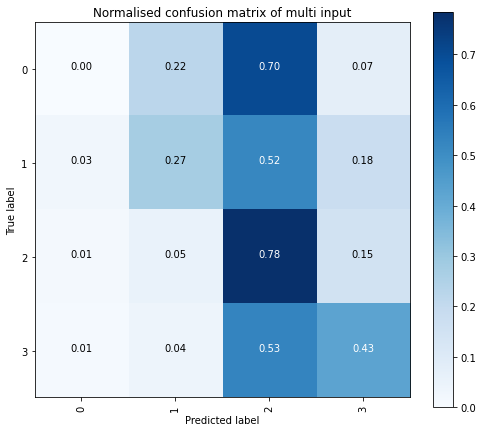

In [32]:
classes = train_descr.loc[:, 'Sentiment'].unique()
classes = classes.sort()

model_path = os.path.join(logdir, 'multi_input_fold')
model = tf.keras.models.load_model(model_path)

y_pred = model.predict([x_test_text, x_test_product_type])
cnf_matrix = confusion_matrix(
    np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# Plot normalised confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)

plot_confusion_matrix(cnf_matrix, classes, PARAMS, normalise=True,
                      title=f'Normalised confusion matrix of multi input')

Confusion matrix, without normalisation


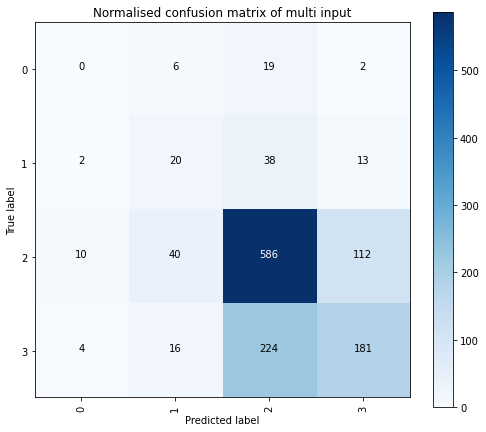

In [33]:
model_path = os.path.join(logdir, 'multi_input_fold')
model = tf.keras.models.load_model(model_path)

y_pred = model.predict([x_test_text, x_test_product_type])
cnf_matrix = confusion_matrix(
    np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# Plot normalised confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)

plot_confusion_matrix(cnf_matrix, classes, PARAMS, normalise=False,
                      title=f'Normalised confusion matrix of multi input')

# Train on the Full Set of Data

In [34]:
x_text_all = np.concatenate((x_train_text, x_test_text), axis=0)
x_product_type_all = np.concatenate(
    (x_train_product_type, x_test_product_type.to_numpy()), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

In [35]:
model_all = model
train_with_cross_val(
    k=PARAMS['k'],
    model=model_all,
    train_text=x_text_all,
    train_product=x_product_type_all,
    train_labels=y_all,
    epochs=PARAMS['epochs'],
    batch_size=PARAMS['batch_size'])

processing fold # 0


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/final_multi_input_model_2020_12_19-22:07/multi_input_fold/assets


In [36]:
history_all_data_df = pd.DataFrame()

for i in range(PARAMS['k']):
    history_all_data = np.load(
        f'history_multi_input_fold_{i}.npy', allow_pickle='TRUE').item()

    history_data_df = pd.DataFrame(history_all_data)

    history_data_df['f1'] = 2 * history_data_df.precision * \
        history_data_df.recall / \
        (history_data_df.precision + history_data_df.recall)
    history_data_df['f1'] = history_data_df['f1'].fillna(0)
    history_data_df['val_f1'] = 2 * history_data_df.val_precision * \
        history_data_df.val_recall / \
        (history_data_df.val_precision + history_data_df.val_recall)
    history_data_df['val_f1'] = history_data_df['val_f1'].fillna(0)

    history_all_data_df = history_all_data_df.append(history_data_df)

history_all_data_df.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,f1,val_f1
0,1.075207,0.577878,0.634622,0.463569,1.014312,0.620365,0.666917,0.558768,0.535774,0.608071
1,1.011487,0.635164,0.684322,0.542327,1.051520,0.633564,0.657447,0.582652,0.605106,0.617794
2,1.005988,0.644755,0.690016,0.562566,1.098850,0.629164,0.653333,0.585167,0.619807,0.617374
3,1.013259,0.649683,0.693460,0.566350,1.160909,0.620365,0.644820,0.575110,0.623492,0.607973
4,1.013895,0.662971,0.707205,0.583861,1.166527,0.607794,0.637068,0.568196,0.639641,0.600664


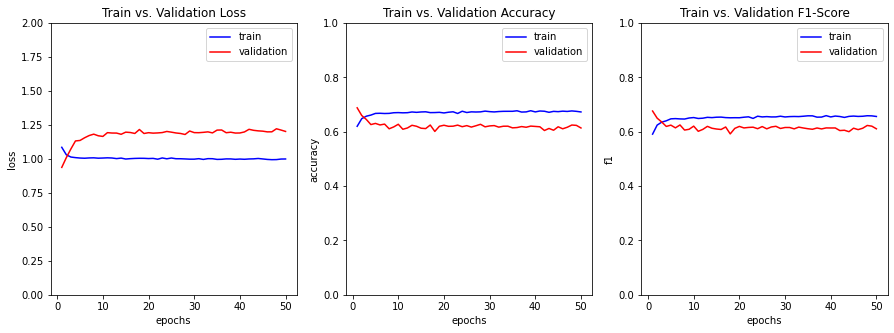

In [37]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)

epochs = PARAMS['epochs']
epochs_graph = range(1, PARAMS['epochs'] + 1)
folds = PARAMS['k']

loss_all = history_all_data_df.loc[:, 'loss'].to_list()
loss_prep = [loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
loss = [np.mean([x[i] for x in loss_prep]) for i in range(epochs)]

val_loss_all = history_all_data_df.loc[:, 'val_loss'].to_list()
val_loss_prep = [
    val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
val_loss = [np.mean([x[i] for x in val_loss_prep]) for i in range(epochs)]

accuracy_all = history_all_data_df.loc[:, 'accuracy'].to_list()
accuracy_prep = [
    accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
accuracy = [np.mean([x[i] for x in accuracy_prep]) for i in range(epochs)]

val_accuracy_all = history_all_data_df.loc[:, 'val_accuracy'].to_list()
val_accuracy_prep = [val_accuracy_all[i *
                                      epochs:(i + 1) * epochs] for i in range(folds)]
val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                for i in range(epochs)]

f1_all = history_all_data_df.loc[:, 'f1'].to_list()
f1_prep = [f1_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

val_f1_all = history_all_data_df.loc[:, 'val_f1'].to_list()
val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
               for i in range(folds)]
val_f1 = [np.mean([x[i] for x in val_f1_prep]) for i in range(epochs)]

plt.plot(epochs_graph, loss, 'b')
plt.plot(epochs_graph, val_loss, 'r')
plt.ylim([0, 2])
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation Loss')

ax = plt.subplot(132)
plt.plot(epochs_graph, accuracy, 'b')
plt.plot(epochs_graph, val_accuracy, 'r')
plt.ylim([0, 1])
ax.set_ylabel('accuracy')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation Accuracy')

ax = plt.subplot(133)
plt.plot(epochs_graph, f1, 'b')
plt.plot(epochs_graph, val_f1, 'r')
plt.ylim([0, 1])
ax.set_ylabel('f1')
ax.set_xlabel('epochs')
ax.legend(['train', 'validation'])
plt.title(f'Train vs. Validation F1-Score')

if logging:
    if not os.path.exists(os.path.join(logdir, 'figures')):
        os.makedirs(os.path.join(logdir, 'figures'))
    fig.savefig(os.path.join(
        logdir, f'figures/loss_accuracy_training_multi_input.png'), bbox_inches='tight')

# On the Side: Create the Text Part, if a model with an Embedding Layer Was Chosen

In [38]:
sequences, word_index, text, labels = load_data(preprocessed_corpus_path_TF)
print(f'Shape of sequences after padding is {text.shape}')

Shape of sequences after padding is (6364, 25)


In [39]:
max_len = np.max([len(x) for x in sequences])
#PARAMS['max_len'] = max_len

In [40]:
# input
text_input = Input(shape=(None,), dtype='int32', name='text')
print(text_input.shape)

# embedding layer
embedded_text = layers.Embedding(
    max_words+1, embedding_size, input_length=max_len)(text_input)
print(embedded_text.shape)

# flatten_text = layers.Flatten()(embedded_text) - for some reason it does not function.
# Therefore, Reshape is used to Flatten the 3D tensor of embeddings
flatten_text = layers.Reshape((max_len * embedding_size,))(embedded_text)
print(flatten_text.shape)

# 2 fully connected layers
encoded_text_1 = layers.Dense(
    hidden_units_text, kernel_regularizer=regularizers.l2(), activation='relu')(flatten_text)
encoded_text_2 = layers.Dropout(0.5)(encoded_text_1)
encoded_text_3 = layers.Dense(hidden_units_text, kernel_regularizer=regularizers.l2(
), activation='relu')(encoded_text_2)
encoded_text_4 = layers.Dropout(0.5)(encoded_text_3)

(None, None)
(None, None, 30)
(None, 750)
